## Numerical Methods In Finance | fall 2024


### *Test*

Please send your file to **vantipov@nes.ru** with topic **"NMF 2024 - Test - Surname"**. Please also rename your file as **"Surname_NMF2024_Test.ipynb"** before sending. If your answer contains many files, please add them to archive (e.g. use zip format) with the same name as the main file.

If you have any questions feel free to ask in Telegram in the group chat.

### 1. Salvaging a linear correlation matrix

You are given a correlation matrix estimated by the historical returns on the following equity stocks **SBER, YDEX, T, MGNT**:

$$\text{C} = \begin{pmatrix} 1 & 0.78 & 0.8 & 0.45 \\ 0.78 & 1 & 0.75 & 0.9 \\ 0.8 & 0.75 & 1 & 0.85 \\ 0.45 & 0.9 & 0.85 & 1 \end{pmatrix}$$

Unfortunately, this correlation matrix is not positive-semidefinite.

On the seminar you faced with two algorithms, based on **hypersphere** and **spectral** decompositions, providing the way on how to adjust a correlation matrix to make it positive-semidefinite. Each of these algorithms have their own pros and cons. Your task is to combine these approaches to construct the new and the best one.

Implement the following algorithm:

1. Apply a **spectral** decomposition algorithm, that is construct a symmetrix positive-definite matrix $\widetilde{\text{C}} = \text{B} \cdot \text{B}^T. $

2. Apply Cholesky decomposition to matrix $\widetilde{\text{C}} = \text{L} \cdot \text{L}^{T}$. 

3. Use matrix $\text{L}$ as an initial guess for the **hyphersphere** decomposition $\widetilde{\text{C}} = \text{B}' \cdot \text{B}'^T$ with reduced number of $\frac{n(n-1)}{2}$ angles, constructed with an optimization procedure.

Your answer should contatin the resulting matrix $\widetilde{\text{C}}$ and the $L_2$ norm between it and the original one. Does this combo-algorithm performs better than each of the algorithms separately?

In [1]:
import numpy as np
import copy
import scipy
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def B(theta: np.ndarray):
    cosine_B = np.cos(theta)
    cosine_B_shifted = np.c_[cosine_B, np.ones(cosine_B.shape[0])]
    sin_B = np.sin(theta)
    sin_B_shifted = np.c_[np.ones(sin_B.shape[0]), sin_B]
    sin_B_shifted_cumprod = np.cumprod(sin_B_shifted, axis=-1)
    return cosine_B_shifted * sin_B_shifted_cumprod


def B_(theta: np.ndarray):
    return np.tril(B(theta))


def reshape_theta_to_appropriate_size(theta: np.ndarray, n: int):
    theta_size = theta.shape[0]
    rows_dim = int(n)
    cols_dim = int(theta_size / rows_dim)
    return theta.reshape(rows_dim, cols_dim)


def l2_norm(theta: np.ndarray, C: np.ndarray, combo: bool = True):
    theta = reshape_theta_to_appropriate_size(theta=theta, n=C.shape[0])
    B_new = B(theta)
    if combo:
        B_new = B_(theta)
    C_approx = B_new @ B_new.T
    return np.linalg.norm(C_approx - C, ord='fro')


def truncate_negative_eigen_values(L: np.ndarray):
    L_ = copy.deepcopy(L)
    L_[np.diag_indices_from(L_)] = np.maximum(np.diag(L_), 0)
    return L_


def scaling_matrix(Q: np.ndarray, L_: np.ndarray):
    return np.diag(1 / np.sum(Q * Q * np.diag(L_), axis=1))


def get_correlation_matrix_for_spectral(Q: np.ndarray, T: np.ndarray, L_: np.ndarray):
    B = np.sqrt(T) @ Q @ np.sqrt(np.abs(L_))
    temp = B @ B.T
    for i in range(len(temp)):
        temp[i][i] = 1.0
    return temp

In [3]:
C = np.array([[1, 0.78, 0.8, 0.45],
             [0.78, 1, 0.75, 0.9],
             [0.8, 0.75, 1, 0.85],
             [0.45, 0.9, 0.85, 1]])

In [4]:
L, Q = scipy.linalg.schur(C)

L_ = truncate_negative_eigen_values(L)
T = scaling_matrix(Q, L_)
C_approx_spec_decomp = get_correlation_matrix_for_spectral(Q, T, L_)
print("L2 norm mimum: \n {} \n".format(
    np.linalg.norm(C_approx_spec_decomp - C, ord='fro')))

L2 norm mimum: 
 0.10085568871109382 



In [5]:
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: \n {} \n".format(C_approx_spec_decomp))

Initial symmetric matrix C: 
 [[1.   0.78 0.8  0.45]
 [0.78 1.   0.75 0.9 ]
 [0.8  0.75 1.   0.85]
 [0.45 0.9  0.85 1.  ]] 

Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: 
 [[1.         0.74884293 0.77233863 0.46075865]
 [0.74884293 1.         0.7541838  0.85715726]
 [0.77233863 0.7541838  1.         0.8128346 ]
 [0.46075865 0.85715726 0.8128346  1.        ]] 



### Combo

In [6]:
L_cholesky = np.linalg.cholesky(C_approx_spec_decomp)
theta = L_cholesky[:, :-1]
theta = theta.reshape(-1)
res = minimize(fun=l2_norm, x0=theta, args=(C, True), method="BFGS")

In [7]:
print("Optimal θ_opt: \n {} \n".format(res.x))
print("L2 norm mimum at given θ_opt: \n {} \n".format(res.fun))

Optimal θ_opt: 
 [-9.22312899e-07  0.00000000e+00  0.00000000e+00  7.13633313e-01
  3.13939661e-06  0.00000000e+00  6.77080934e-01  1.10441531e+00
  1.57195489e-06  1.07266071e+00  4.91697066e-01  1.41982964e-06] 

L2 norm mimum at given θ_opt: 
 0.09050742854294337 



In [8]:
theta_opt = res.x
theta_opt_reshaped = reshape_theta_to_appropriate_size(theta=theta_opt, n=4)
C_approx_opt = B(theta_opt_reshaped) @ B(theta_opt_reshaped).T
print("Initial symmetric matrix C: \n {} \n".format(C))
print(
    "Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization and Shura: \n {} \n".format(
        C_approx_opt)
)

Initial symmetric matrix C: 
 [[1.   0.78 0.8  0.45]
 [0.78 1.   0.75 0.9 ]
 [0.8  0.75 1.   0.85]
 [0.45 0.9  0.85 1.  ]] 

Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization and Shura: 
 [[1.         0.75598796 0.77940463 0.47778784]
 [0.75598796 1.         0.77363145 0.86811697]
 [0.77940463 0.77363145 1.         0.822652  ]
 [0.47778784 0.86811697 0.822652   1.        ]] 



### Hyphersphere

In [9]:
theta = np.random.rand(12)
res = minimize(fun=l2_norm, x0=theta, args=(C, False), method="BFGS")

In [10]:
print("Optimal θ_opt: \n {} \n".format(res.x))
print("L2 norm mimum at given θ_opt: \n {} \n".format(res.fun))

Optimal θ_opt: 
 [ 0.0844732   1.69176228  1.05293024  0.65539335 -0.61860693  1.26527376
  0.70182988  0.72122083  0.19688539  1.04648008  0.40377528 -0.98949649] 

L2 norm mimum at given θ_opt: 
 0.0905074285403229 



In [11]:
theta_opt = res.x
theta_opt_reshaped = reshape_theta_to_appropriate_size(theta=theta_opt, n=4)
C_approx_opt = B(theta_opt_reshaped) @ B(theta_opt_reshaped).T
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: \n {} \n".format(C_approx_opt))

Initial symmetric matrix C: 
 [[1.   0.78 0.8  0.45]
 [0.78 1.   0.75 0.9 ]
 [0.8  0.75 1.   0.85]
 [0.45 0.9  0.85 1.  ]] 

Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: 
 [[1.         0.75598865 0.77940493 0.47778861]
 [0.75598865 1.         0.77363048 0.86811605]
 [0.77940493 0.77363048 1.         0.82265219]
 [0.47778861 0.86811605 0.82265219 1.        ]] 



### 2. Monte-Carlo integration

Having constructed the positive-semidefintie correlation matrix, you need to use it to price a basket option on **SBER** and **MGNT**.

The payoff of your option at expiration $T$ is 

$$\text{Payoff}(S^{SBER}_T, S^{MGNT}_T) = \left(\frac{1}{2} \left(\frac{S^{SBER}_T}{S^{SBER}_0} + \frac{S^{MGNT}_T}{S^{MGNT}_0}\right) - 100\% \right)_{+}.$$

Assume that each stock evolves as a geometric Brownian motion:

$$S^{SBER}_T = S^{SBER}_0 e^{(r - (\sigma^{SBER})^2/2)T + \sigma^{SBER} W^{SBER}_T}, \quad S^{MGNT}_T = S^{MGNT}_0 e^{(r - (\sigma^{MGNT})^2/2)T + \sigma^{MGNT} W^{MGNT}_T},$$

where $W^{SBER}_T$ and $W^{MGNT}_T$ are Brownian motions correlated with $\rho^{SBER, MGNT}$. 

The price of the option can be expressed as the following expectation

$$P = e^{-rT} \cdot \mathbb{E}^{\mathbb{Q}} [\text{Payoff}(S^{SBER}_T, S^{MGNT}_T)],$$

wich can be evaluated using Monte-Carlo algorithm.

You may assume that risk-free interest rate $r = 21\%$, the initial stock prices are $S^{SBER}_0 = 230$, $S^{MGNT}_0 = 4300$ and the volatilities are $\sigma^{SBER}_0 = 30\%$, $\sigma^{MGNT}_0 = 40\%$. The maturity of the option $T$ is equal to on year.

Your answer should contatin the plot of the price $P$ of the option as a function on number of Monte-Carlo simulations $N$. Does your algorithm converges? What is the speed of the convergence as a function of $N$? 

In [12]:
def sample_independent_uniform_variates(n_sample: int, size: int = 1, random_seed: int = 42):
    np.random.seed(random_seed)
    return np.random.rand(n_sample, size)


def cholesky_decomposition(x: np.ndarray):
    return np.linalg.cholesky(x)


def transform_gaussian_to_uniform(gaussian_sample: np.ndarray):
    return norm.cdf(gaussian_sample)


def transform_uniform_to_gaussian(uniform_sample: np.ndarray):
    return norm.ppf(uniform_sample)


def transform_to_log_norm(sample: np.ndarray):
    T = 1
    r = 0.21
    S_magn_initial = 4300
    S_sber_initial = 230
    sigma_magn = 0.3
    sigma_sber = 0.4
    result = np.zeros_like(sample)
    result[:, 0] = np.exp(r - (sigma_magn**2) / 2 + sigma_magn*sample[:, 0])
    result[:, 1] = np.exp(r - (sigma_sber**2) / 2 + sigma_sber*sample[:, 1])

    return result


def gaussian_copula(n_sample: int, corr_matrix: np.ndarray):
    size = corr_matrix.shape[0]
    sample_of_independent_uniform_variates = sample_independent_uniform_variates(
        n_sample=n_sample, size=size)
    sample_of_independent_standard_gaussian_variates = transform_uniform_to_gaussian(
        uniform_sample=sample_of_independent_uniform_variates)
    square_root_matrix = cholesky_decomposition(x=corr_matrix)
    sample_of_codependent_standard_gaussian_variates = sample_of_independent_standard_gaussian_variates @ square_root_matrix.T
    sample_of_codependent_uniform_variates = transform_gaussian_to_uniform(
        gaussian_sample=sample_of_codependent_standard_gaussian_variates
    )
    return sample_of_codependent_uniform_variates


def payoff(sample_of_gaussian_variates_1: np.ndarray, sample_of_gaussian_variates_2: np.ndarray):
    return np.mean(
        np.maximum(
            0.5*(sample_of_gaussian_variates_1 +
                 sample_of_gaussian_variates_2) - 1.0,
            0.0
        )
    )


def convergence_analysis(sample_of_codependent_gaussian_variates: np.ndarray, true_results: float):
    maximum_number_of_iterations = sample_of_codependent_gaussian_variates.shape[0]
    results = np.zeros((int(np.log2(maximum_number_of_iterations)), 1))
    for i in range(results.shape[0]):
        results[i, 0] = np.abs(
            np.exp(-0.21)*payoff(
                sample_of_gaussian_variates_1=sample_of_codependent_gaussian_variates[:2**i, 0],
                sample_of_gaussian_variates_2=sample_of_codependent_gaussian_variates[:2**i, 1]
            ) - true_results
        )
    return results

In [13]:
corr_matrix = C_approx_opt[0::3, 0::3]
sample_of_codependent_uniform_variates = gaussian_copula(
    n_sample=2**19,
    corr_matrix=corr_matrix
)
sample_of_transformed_back_codependent_gaussian_variates = transform_to_log_norm(
    transform_uniform_to_gaussian(
        uniform_sample=sample_of_codependent_uniform_variates
    )
)

T = 1
r = 0.21
sigma_magn = 0.3
sigma_sber = 0.4

convergence_result = convergence_analysis(
    sample_of_codependent_gaussian_variates=sample_of_transformed_back_codependent_gaussian_variates,
    # true_results=0.5*(np.exp(r - (sigma_magn**2)/2) +
    #                   np.exp(r - (sigma_sber**2)/2)
    #                   )
    true_results=0
)

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_13483/3052230965.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\log_2(N)$, $N$ - number of samples")
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_13483/3052230965.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


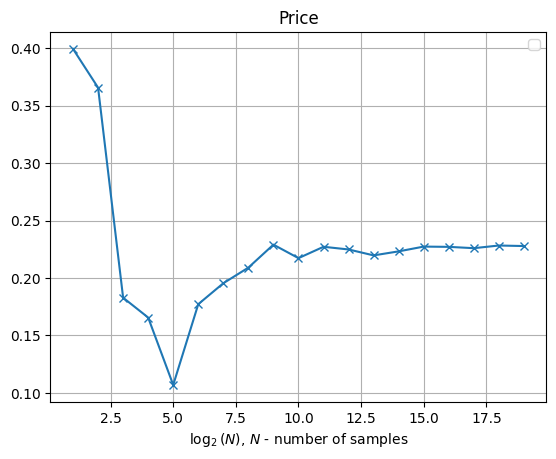

In [14]:
log_2_iteratinos = np.linspace(1, 19, 19)
one_over_sqrt_N = 1 / np.sqrt([2**i for i in range(log_2_iteratinos.shape[0])])
one_over_sqrt_N
plt.plot(
    log_2_iteratinos,
    convergence_result[:, 0],
    marker="x"
)
plt.title('Price')
plt.xlabel("$\log_2(N)$, $N$ - number of samples")
plt.legend()
plt.grid()
plt.show()

### TODO: посчитать ручками матожидание payoff

### 3. Implied volatilities interpolation

You are observing the following  implied volatilities for maturity $T=1$: 

$$K/S_0 = \{ 26\%, \quad 37\%, \quad 52\%, \quad 70\%, \quad 100\%, \quad 142\%, \quad 195\% \}$$
$$\sigma^{IV} = \{ 42.5\%, \quad 37.5\%, \quad 32.5\%, \quad 28.5\%, \quad 25\%, \quad 23\%, \quad 22\% \}$$

Assume that the risk-free interest rate is zero and the spot $S_0 = 1$.

Provide an interpolation algorithm (cubic splines, rational cubic splines or whatever you want) for the given implied volatilities. You **can not** use any algorithms built into scipy, numpy, or any other python module - use your one realization! Is your interpolation free of monotonicity ($C'(K) > 0$) and butterfly ($C''(K) > 0$) arbitrage? Your answer should contain a plot with interpolated implied volatilities as well as a numerical check that your interpolation does not violate no-arbitrage conditions described above. 

In [ ]:
log_moneyness = np.array([26, 37, 52, 70, 100, 142, 195]) / 100.
sigma_iv = np.array([42.5, 37.5, 32.5, 28.5, 25, 23, 22]) / 100.

### 4. Pricing options within finite-differencing framework

Your task is to price European/American options within finite-differencing approach. You may assume you are given an implied volatilities (together with your interpolation method) from the previous task. 

1. Price within a finite-differencing method a European put option with strike $K=70\%$ and a European call option with strike $K = 130\%$. Use any numerical scheme you wish. Compare your results with the ones obtained analytically from Black-Scholes formula. How your results differ from the analytic ones?

2. Price within a finite-differencing method an American put option with strike $K=70\%$. Please note that an American option can be exercised at any time before the maturity if its intrinsic value is greater than calculated option price at that step. Use any numerical scheme you wish. Please describe the way how option's "American" property affects your finite-differencing algorithm when you are stepping in time. How its price differs from the price of European option with the same strike? 

You may use your own implementation of finite differencing algorithm or the one presented on the seminar.

### 1.

In [17]:
import numpy as np
from scipy.stats import norm
from scipy.sparse.linalg import splu, spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from pde_solver import solve_1d_pde, FiniteDifferencingScheme
from pricer import price, OptionType
from typing import Union

In [18]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float],
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))

In [25]:
number_of_time_steps = 31
finite_differencing_spacial_levels = 51
number_of_std_deviations = 4
scheme_type = FiniteDifferencingScheme.Implicit
number_of_spatial_levels, number_of_time_steps = 201, 201


def pde_coefficients(_): return {
    "U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}

In [29]:
spot = 100.
r, sigma = 0.12, 0.2
# maturities = np.array([1/12, 3/12, 6/12, 1])
maturities = np.linspace(1/12, 1, 10)
strikes = np.linspace(spot * 0.7, spot * 1.3, 2)
print(strikes)
trade_values_calls = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_calls_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))

for i, maturity in enumerate(maturities):
    for j, strike in enumerate(strikes):
        trade_values_calls[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.CALL,
                                         number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                         pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                         volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)

        trade_values_calls_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                  forward=spot *
                                                  np.exp(r * maturity),
                                                  vol=sigma,
                                                  df=np.exp(-r * maturity),
                                                  T=maturity,
                                                  theta=1)

        trade_values_puts[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.PUT,
                                        number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                        pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                        volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)

        trade_values_puts_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                 forward=spot *
                                                 np.exp(r * maturity),
                                                 vol=sigma,
                                                 df=np.exp(-r * maturity),
                                                 T=maturity,
                                                 theta=-1)

[ 70. 130.]


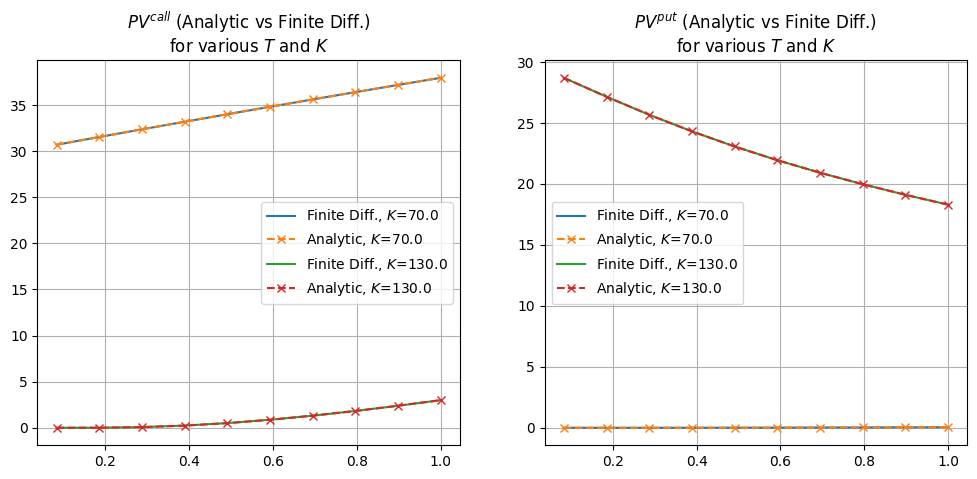

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, _ in enumerate(strikes):
    ax[0].plot(maturities, trade_values_calls[:, i],
               label="Finite Diff., $K$={}".format(_), linestyle="-")
    ax[0].plot(maturities, trade_values_calls_analytic[:, i],
               label="Analytic, $K$={}".format(_), linestyle="--", marker="x")

    ax[1].plot(maturities, trade_values_puts[:, i],
               label="Finite Diff., $K$={}".format(_), linestyle="-")
    ax[1].plot(maturities, trade_values_puts_analytic[:, i],
               label="Analytic, $K$={}".format(_), linestyle="--", marker="x")

ax[0].set_title(
    '$PV^{call}$ (Analytic vs Finite Diff.)\n' + 'for various $T$ and $K$')
ax[1].set_title('$PV^{put}$ (Analytic vs Finite Diff.)\n' +
                'for various $T$ and $K$')
ax[0].grid(), ax[1].grid()
ax[0].legend(), ax[1].legend()
plt.show()